In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
#metrics
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score
from Weed_dataset import WeedDataset
from torch.utils.data import DataLoader
from experimental_models.Unet_with_custom_backbone.arch import Architecture
from experimental_models.encoder_decoder.base_arch import MyArch
from experimental_models.encoder_decoder_dilated.dilated import MyArch_Dilated
from data_script import read_file

/Users/smudge/Desktop/code/research/weed-detection/.venv/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/smudge/Desktop/code/research/weed-detection/.venv/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still chang

In [3]:
#load model and samples

model=Architecture().to(device=torch.device('cpu'))
model.load_state_dict(torch.load("./models/our_model/run_7/model250.pth"))

model1=MyArch().to(torch.device("cpu"))
model1.load_state_dict(torch.load("./models/encoder_decoder/model280.pth"))

train,test=read_file()

dataset=WeedDataset(test,training=False)
loader=DataLoader(dataset,batch_size=30,shuffle=False)



l=list()
for i,(x_sample,y_sample) in enumerate(loader):
    x_sample=x_sample.to(device=torch.device("cpu"))
    y_sample=y_sample.to(device=torch.device("cpu"))

    predictions_unet=model(x_sample)
    predictions_enc=model1(x_sample)

    predictions=(0.85*predictions_unet+0.60*predictions_enc)/1.45
    

In [4]:
#convert to HXWXC vectors

x_sample=x_sample.to(device=torch.device("cpu"))
x_sample=x_sample.permute(0,2,3,1)

y_sample=y_sample.to(device=torch.device("cpu"))
y_sample=y_sample.permute(0,2,3,1)


In [5]:
x_sample.shape

torch.Size([30, 1024, 1024, 3])

In [6]:
predictions.size()

torch.Size([30, 3, 1024, 1024])

In [17]:
#load saved weights
predictions=torch.load("./predictions/predictions_8_best.pt")

In [18]:
import torch.nn.functional as f

predictions=predictions.to(device=torch.device("cpu"))

probs=f.softmax(predictions,dim=1)
preds=torch.argmax(probs,dim=1)
predictions_probs=torch.zeros_like(probs).scatter_(1,preds.unsqueeze(1),1.)

predictions_probs=predictions_probs.permute(0,2,3,1)
    

Text(0.5, 1.0, 'Ground Truth')

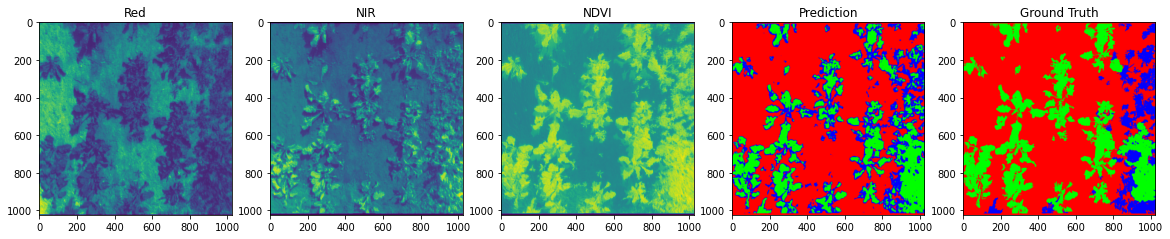

In [9]:
#Visualize

t=1
fig=plt.figure(figsize=(20,20),dpi=72)
ax1=fig.add_subplot(1,5,1)
ax1.imshow(x_sample[t,:,:,0])
ax1.set_title("Red")

ax2=fig.add_subplot(1,5,2)
ax2.imshow(x_sample[t,:,:,1])
ax2.set_title("NIR")

ax3=fig.add_subplot(1,5,3)
ax3.imshow(x_sample[t,:,:,2])
ax3.set_title("NDVI")


ax4=fig.add_subplot(1,5,4)
ax4.imshow(predictions_probs[t])
ax4.set_title("Prediction")

ax5=fig.add_subplot(1,5,5)
ax5.imshow(y_sample[t])
ax5.set_title("Ground Truth")

In [19]:
#convert to numpy and flatten by (BXHXW,4)

y_np=y_sample.numpy()
pred_np=predictions_probs.numpy()

In [20]:
y_np=np.reshape(y_np,(y_np.shape[0]*y_np.shape[1]*y_np.shape[2],3))
pred_np=np.reshape(pred_np,(pred_np.shape[0]*pred_np.shape[1]*pred_np.shape[2],3))


In [21]:
y_labels=np.where(y_np==1)[1]
pred_labels=np.where(pred_np==1)[1]

In [27]:
#metrics
f1=f1_score(y_labels,pred_labels,average='weighted')
precision=precision_score(y_labels,pred_labels,average='weighted')
recall=recall_score(y_labels,pred_labels,average='weighted')

In [28]:
f1

0.7990300455379813

In [29]:
precision

0.8458289935564757

In [31]:
recall

0.7744272232055665

In [22]:
cf_true=confusion_matrix(y_labels,pred_labels,normalize='true')

In [23]:
cf_true

array([[0.88831775, 0.00843174, 0.10325051],
       [0.01123321, 0.60306945, 0.38569734],
       [0.04001412, 0.34128986, 0.61869602]])

In [1]:
torch.save(predictions,"./predictions/predictions_8_best.pt")

NameError: name 'torch' is not defined

<Axes: >

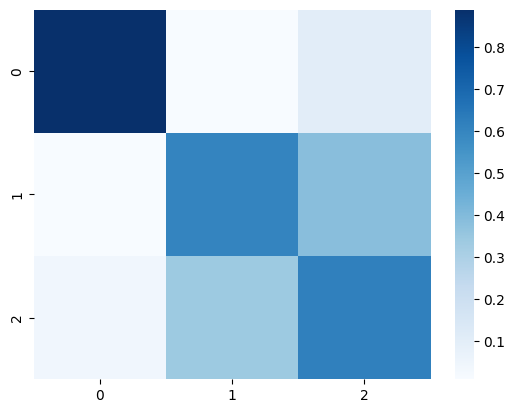

In [15]:
#print the confusion matrix
import seaborn as sb 
sb.heatmap(cf_true,cmap='Blues')

<Axes: >

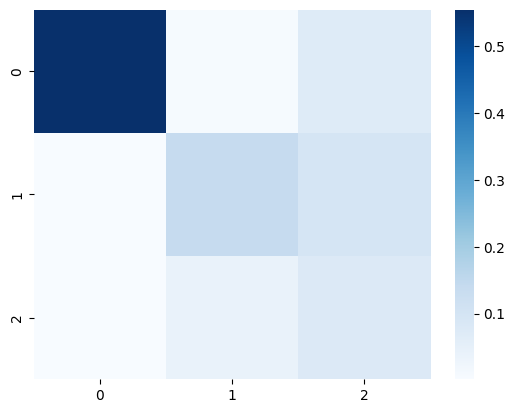

In [26]:
#For true positive rates
cf=confusion_matrix(y_labels,pred_labels,normalize='all')

sb.heatmap(cf,cmap='Blues')